# MNIST DATASET

## Seeding the model

From talking with our lecturer I found that it was best to seed the random weight generator to get reproducible results. As TensorFlow will automatically assign random weights on each run based on probibility. To achieve this I found documentation on the Keras website below, which I have adapted.

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K

Using TensorFlow backend.


The below is necessary for starting Numpy and core Python generated random numbers in a well-defined initial state.

In [2]:
np.random.seed(42)
rn.seed(12345)

Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
For further details, see: https://stackoverflow.com/questions/42022950/

In [3]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state. For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

In [4]:
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Train the model

In [5]:
# Additional Imports
import keras as kr
from keras.models import load_model # To save and load models.
import sklearn.preprocessing as pre # For encoding categorical variables.
import gzip # Extract and read gzip format.
%matplotlib inline
import matplotlib.pyplot as plt # Plot results graphically.

### Read in the training and test images with labels using gzip.

In [6]:
# Test Images (60000)
with gzip.open('MNIST_Images/train-images-idx3-ubyte.gz', 'rb') as f:
    train_imgs = f.read()

with gzip.open('MNIST_Images/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_lbls = f.read()

# Training Images (10000)
with gzip.open('MNIST_Images/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_imgs = f.read()

with gzip.open('MNIST_Images/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_lbls = f.read()

### Set up a neural network model, building it layer by layer sequentially.

In [7]:
model = kr.models.Sequential()

Add a hidden layer with 1000 neurons and an input layer with 784 inputs.
* 784 is the number of bytes per image (28 x 28)
* A dense layers means that each neuron recieves input from all the neurons in the previous layer (all connected)
* **linear activation function** = Takes the inputs, multiplied by the weights for each neuron, and creates an output proportional to the input. 
* **relu activation function** = (Rectified Linear Unit) All positive values stay the same and all negative values are changed to zero.

In [8]:
model.add(kr.layers.Dense(units=600, activation='linear', input_dim=784))
model.add(kr.layers.Dense(units=400, activation='relu')) 

Add a 10 neuron output layer, each output will represent a possible label from 0-9.
* softmax - normalizes all outputs so must add up to 1. So the largest weighted result will be the most probable number.
* E.g [0.1, 0.7, 0.1, 0.01...] it will choose 0.7

In [9]:
model.add(kr.layers.Dense(units=10, activation='softmax'))

#### Build the graph.
* categorical_crossentropy - loss function that is used for single label categorization. Used classification problems where only one result can be correct. E.g number is a 9
* adam - Computationally efficient and benefits from both AdaGrad and RMSProp optimizers.
* accuracy - Display accuracy results when training

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Parse image and labels into lists
The bitwise operator ~ (tilde) is a complement operator. It takes one bit operand and returns its complement. If the operand is 1, it returns 0, and if it is 0, it returns 1

In [11]:
train_imgs = ~np.array(list(train_imgs[16:])).reshape(60000, 28, 28).astype(np.uint8) / 255.0
train_lbls =  np.array(list(train_lbls[ 8:])).astype(np.uint8)
inputs = train_imgs.reshape(60000, 784)

#### Encode labels into binary using sklearn, so they can be compared easily.
E.g 0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] etc.

In [12]:
encoder = pre.LabelBinarizer()
encoder.fit(train_lbls)
outputs = encoder.transform(train_lbls)

In [13]:
train_lbls[0], outputs[0]

(5, array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

Print out binary value for each number 0-9. 

In [14]:
for i in range(10):
    print(i, encoder.transform([i]))

0 [[1 0 0 0 0 0 0 0 0 0]]
1 [[0 1 0 0 0 0 0 0 0 0]]
2 [[0 0 1 0 0 0 0 0 0 0]]
3 [[0 0 0 1 0 0 0 0 0 0]]
4 [[0 0 0 0 1 0 0 0 0 0]]
5 [[0 0 0 0 0 1 0 0 0 0]]
6 [[0 0 0 0 0 0 1 0 0 0]]
7 [[0 0 0 0 0 0 0 1 0 0]]
8 [[0 0 0 0 0 0 0 0 1 0]]
9 [[0 0 0 0 0 0 0 0 0 1]]


https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
Rather than retraining the model again and again I wanted to be able to save and load it, so I researched and found a way to achieve this.


In [15]:
try:
    model = load_model('test_model.h5')
except:
    # If model isn't found train model using 8 epochs
    # From testing it seems to peak at accuracy at around 8 epochs
    # One Epoch is when an entire dataset is passed forward and backward through the neural network only once.
    model_log = model.fit(inputs, outputs, epochs=8, batch_size=100)
    model.save('test_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/8
60000/60000 [==============================] - 8s 125us/step - loss: 0.5157 - acc: 0.8445
Epoch 2/8
60000/60000 [==============================] - 8s 129us/step - loss: 0.2313 - acc: 0.9285
Epoch 3/8
60000/60000 [==============================] - 7s 114us/step - loss: 0.1765 - acc: 0.9451
Epoch 4/8
60000/60000 [==============================] - 6s 104us/step - loss: 0.1589 - acc: 0.9503
Epoch 5/8
60000/60000 [==============================] - 7s 113us/step - loss: 0.1354 - acc: 0.9579
Epoch 6/8
60000/60000 [==============================] - 8s 135us/step - loss: 0.1269 - acc: 0.9599
Epoch 7/8
60000/60000 [==============================] - 7s 121us/step - loss: 0.1206 - acc: 0.9629
Epoch 8/8
60000/60000 [==============================] - 7s 112us/step - loss: 0.1219 - acc: 0.9630


Display accuracy and loss results on a graph

Code adapted from: https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a

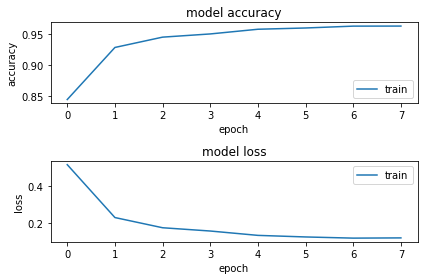

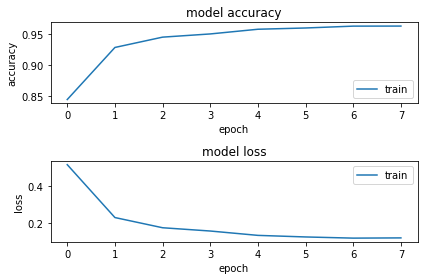

In [17]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

# Test the model.

Parse images and labels into lists.

In [18]:
test_imgs = ~np.array(list(test_imgs[16:])).reshape(10000, 784).astype(np.uint8) / 255.0
test_lbls =  np.array(list(test_lbls[ 8:])).astype(np.uint8)

Calculate the sum of correct results out of all 10000 images using the labels
* Last test returned a result of 9706. 

In [19]:
print("\nSum of correct results:", (encoder.inverse_transform(model.predict(test_imgs)) == test_lbls).sum())


Sum of correct results: 9685


#### Predict image using model
Last test returned a 6 which is correct.

In [20]:
print("\nTest image:", model.predict(test_imgs[11:12]))


Test image: [[1.2899625e-06 2.1695709e-12 1.4391152e-07 8.9484749e-09 1.2113215e-09
  1.2421596e-04 9.9985826e-01 7.8540167e-11 1.6046946e-05 4.2257585e-13]]


From testing the model.predict it would return an array of possibilities. The highest value would be the right answer.
To get the largest value I looked up a numpy methods and found argmax() to achieve this.
https://kite.com/python/examples/5750/numpy-find-the-index-of-the-largest-element-of-an-array

In [21]:
print("\nResults:", model.predict(test_imgs[11:12]).argmax())


Results: 6


Display correct image which should be a 6.

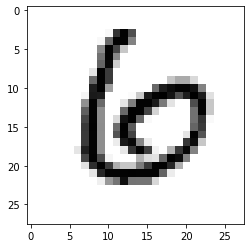

In [22]:
plt.imshow(test_imgs[11].reshape(28, 28), cmap='gray')
plt.show()